# Deberta fine tuning
<br>
James Chapman<br>
CIS 830 Advanced Topics in AI – Term Project<br>
Kansas State University<br><br>

This notebook finetunes LLMs with data from the paper [Robust Drug Use Detection on X: Ensemble Method with a Transformer Approach](https://doi.org/10.1007/s13369-024-08845-6).<br>

#### Binary classification: about illicit/abusive drug use or not. <br>

#### Results: Very close to the results of the paper (bottom cell)<br>

TODO: train with larger models (Qwen etc.). This notebook includes quantization to fit on smaller GPus if need be.
- Al-Ghannam, R., Ykhlef, M. & Al-Dossari, H. Robust Drug Use Detection on X: Ensemble Method with a Transformer Approach. Arab J Sci Eng 49, 12867–12885 (2024). https://doi.org/10.1007/s13369-024-08845-6


In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from dataclasses import asdict
from tqdm.notebook import tqdm
tqdm.pandas()

# from llama_cookbook.configs import lora_config as LORA_CONFIG
# from llama_cookbook.configs import train_config as TRAIN_CONFIG
# from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig

from transformers import (
    AutoModelForSequenceClassification, # LlamaForSequenceClassification, 
    AutoTokenizer, 
#     BitsAndBytesConfig, 
    TrainingArguments, 
    Trainer, 
    DataCollatorWithPadding, 
    logging, 
    ProgressCallback,
    EarlyStoppingCallback
)

logging.set_verbosity_info()
torch.backends.cuda.enable_flash_sdp(True)  
torch.set_float32_matmul_precision('high')   # avoid down‑casting matmuls

In [2]:
#"microsoft/deberta-v3-large" "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
model_name = "microsoft/deberta-v3-large"
output_dir = "deberta2"

# Convert TRAIN_CONFIG to HF TrainingArguments (with legacy flags)
training_args = TrainingArguments(
    output_dir                  = output_dir,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 4,
    learning_rate               = 2e-5,
    warmup_ratio                = 0.10,
    max_grad_norm               = 1.0,       
    lr_scheduler_type           = "cosine",
    weight_decay                = 0.02,
    disable_tqdm                = False,
    num_train_epochs            = 15,
    # fp16                        = True,
    do_eval                     = True,
    do_train                    = True,
    save_total_limit            = 500,
    logging_dir                 = f"{output_dir}/logs",
    logging_steps               = 50,
    eval_strategy               = "steps",    
    save_strategy               = "steps",    
    eval_steps                  = 500,
    save_steps                  = 500,
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy", # Or "accuracy"
    greater_is_better           = True,
)

##########################################################################
# # LORA & QLoRA

# lora_config = LORA_CONFIG()
# lora_config.r = 8
# lora_config.lora_alpha = 32
# lora_config.lora_dropout = 0.01

# peft_config = LoraConfig(**asdict(lora_config))
# for quantization
# bnb_cfg = BitsAndBytesConfig( #load_in_8bit=True)
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=torch.bfloat16,   # 4090 handles bf16 natively
#     bnb_4bit_quant_type="nf4",
# )
##########################################################################

model = AutoModelForSequenceClassification.from_pretrained( #LlamaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    device_map="auto",
    #quantization_config=bnb_cfg, # comment out for no quantization
    #use_cache=False,
    #torch_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Pin pad token so Trainer can batch >1
if tokenizer.pad_token_id is None:
    tokenizer.add_special_tokens({"pad_token":"[PAD]"})
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id

# model = prepare_model_for_kbit_training(model) # comment out for no quantization
# model = get_peft_model(model, peft_config)
# model.gradient_checkpointing_enable() # comment out for no quantization


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at C:\Users\James\.cache\huggingface\hub\models--microsoft--deberta-v3-large\snapshots\64a8c8eab3e352a784c658aef62be1662607476f\config.json
Model config DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "po

In [3]:
# Load CSV
csv_path = r"C:\Users\James\OneDrive\Kansas State University\CIS 830\Project_SparKG\data\Robust_Drug_Use_Detection_data_consolidated.csv"
robust_data = pd.read_csv(csv_path, encoding="utf-8-sig")
# Remove all @mentions using regex
robust_data["text"] = robust_data["text"].str.replace(r'@\w+', '', regex=True).str.strip()
robust_data.info(verbose=True)
for element in robust_data["text"][:5]:
    print(element)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112057 entries, 0 to 112056
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    112057 non-null  object
 1   label   112057 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB
Voice crack list : 
changbin
leeknow
hyunjin
Lmao I do always have voice cracks when I'm too tired singing for a long time #StrayKids #MANIAC_SKZ #2ndWorldTour_MANIAC
Don't tell my boss but the reason I'm late to work today is because I slightly OD'd on heroin while watching MORBIUS on repeat last night for the ultimate high and euphoria. Had to take a lil visit to the ER but it's ok they had MORBIUS on the tv in my room
Drugs have gone too far..Even the chickens doing heroin..
I need another drug dealer show. I need some killer flicks 😂 it's something w me
Doctor DESTROYS Derek Chauvin's defense that George Floyd died of a drug overdose


In [4]:
# splits
train_val_df, test_df = train_test_split(robust_data, test_size=0.20, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_val_df, test_size=0.125, random_state=42, shuffle=True)

raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

#  Tokenize & set up labels
#  map 'T'→1, 'F'→0 and feed both text and labels into the model.
def preprocess_fn(batch):
    enc = tokenizer(
        batch["text"],
        truncation=True,
        padding="longest",   # or True/"max_length" if you prefer dynamic
        max_length=128,
    )
    # classification labels
    enc["labels"] = [1 if l == "T" else 0 for l in batch["label"]]
    return enc

tokenized = raw_datasets.map(
    preprocess_fn,
    batched=True,
    remove_columns=["text", "label"],
)

# Rename "label" → "labels" ?
for split in ("train", "validation", "test"):
    if "label" in tokenized[split].column_names:
        tokenized[split] = tokenized[split].rename_column("label", "labels")

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/78439 [00:00<?, ? examples/s]

Map:   0%|          | 0/11206 [00:00<?, ? examples/s]

Map:   0%|          | 0/22412 [00:00<?, ? examples/s]

In [5]:
# Metrics callback!
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "f1":        f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall":    recall_score(labels, preds),
    }

model.to("cuda")
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = tokenized["train"],
    eval_dataset    = tokenized["validation"],
    tokenizer       = tokenizer,
    data_collator   = data_collator,
    compute_metrics = compute_metrics,
)

# Kick off training
trainer.add_callback(ProgressCallback)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=10)) # Stops if metric doesn't improve for 3 evaluations
trainer.train()

C:\Users\James\AppData\Local\Temp\ipykernel_22940\4204036879.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
***** Running training *****
  Num examples = 78,439
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 18,375
  Number of trainable parameters = 435,063,810


  0%|          | 0/18375 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.299400,0.296870,0.889702,0.878918,0.832745,0.930512
1000,0.263400,0.272059,0.901928,0.887155,0.878406,0.896080
1500,0.227800,0.248460,0.905051,0.894549,0.856519,0.936113
2000,0.227300,0.246395,0.907728,0.898368,0.853727,0.947936
2500,0.205100,0.237555,0.915492,0.903476,0.888176,0.919311
3000,0.207200,0.236146,0.912190,0.900061,0.881791,0.919104
3500,0.200000,0.225270,0.915492,0.905461,0.872787,0.940676
4000,0.177100,0.230818,0.913707,0.902096,0.881131,0.924082
4500,0.163800,0.279700,0.911744,0.900111,0.877165,0.924290
5000,0.133300,0.281708,0.906746,0.893073,0.881260,0.905206


{'loss': 0.6824, 'grad_norm': 2.3581228256225586, 'learning_rate': 5.331882480957563e-07, 'epoch': 0.04}
{'loss': 0.6854, 'grad_norm': 1.1751478910446167, 'learning_rate': 1.0772578890097933e-06, 'epoch': 0.08}
{'loss': 0.6811, 'grad_norm': 5.2011518478393555, 'learning_rate': 1.6213275299238303e-06, 'epoch': 0.12}
{'loss': 0.6233, 'grad_norm': 4.52703857421875, 'learning_rate': 2.1653971708378674e-06, 'epoch': 0.16}
{'loss': 0.4542, 'grad_norm': 3.308579444885254, 'learning_rate': 2.7094668117519044e-06, 'epoch': 0.2}
{'loss': 0.3658, 'grad_norm': 2.1319828033447266, 'learning_rate': 3.2535364526659415e-06, 'epoch': 0.24}
{'loss': 0.3149, 'grad_norm': 4.378939628601074, 'learning_rate': 3.7976060935799785e-06, 'epoch': 0.29}
{'loss': 0.3265, 'grad_norm': 1.6151182651519775, 'learning_rate': 4.341675734494016e-06, 'epoch': 0.33}
{'loss': 0.2942, 'grad_norm': 3.2831614017486572, 'learning_rate': 4.885745375408053e-06, 'epoch': 0.37}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.2994, 'grad_norm': 2.248960256576538, 'learning_rate': 5.42981501632209e-06, 'epoch': 0.41}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.2968699336051941, 'eval_accuracy': 0.8897019453864001, 'eval_f1': 0.8789184952978056, 'eval_precision': 0.8327454984221273, 'eval_recall': 0.930512341837793, 'eval_runtime': 22.6235, 'eval_samples_per_second': 495.325, 'eval_steps_per_second': 30.985, 'epoch': 0.41}


Saving model checkpoint to deberta2\checkpoint-500
Configuration saved in deberta2\checkpoint-500\config.json
Model weights saved in deberta2\checkpoint-500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-500\special_tokens_map.json


{'loss': 0.3032, 'grad_norm': 2.277647018432617, 'learning_rate': 5.973884657236127e-06, 'epoch': 0.45}
{'loss': 0.2758, 'grad_norm': 1.8259007930755615, 'learning_rate': 6.517954298150164e-06, 'epoch': 0.49}
{'loss': 0.2851, 'grad_norm': 2.3748481273651123, 'learning_rate': 7.062023939064201e-06, 'epoch': 0.53}
{'loss': 0.2902, 'grad_norm': 2.715031385421753, 'learning_rate': 7.606093579978238e-06, 'epoch': 0.57}
{'loss': 0.2877, 'grad_norm': 3.4202487468719482, 'learning_rate': 8.150163220892275e-06, 'epoch': 0.61}
{'loss': 0.2854, 'grad_norm': 1.8564929962158203, 'learning_rate': 8.694232861806313e-06, 'epoch': 0.65}
{'loss': 0.2728, 'grad_norm': 1.8036695718765259, 'learning_rate': 9.238302502720349e-06, 'epoch': 0.69}
{'loss': 0.2725, 'grad_norm': 1.7602554559707642, 'learning_rate': 9.782372143634385e-06, 'epoch': 0.73}
{'loss': 0.2561, 'grad_norm': 2.401947021484375, 'learning_rate': 1.0326441784548422e-05, 'epoch': 0.78}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.2634, 'grad_norm': 1.3561022281646729, 'learning_rate': 1.087051142546246e-05, 'epoch': 0.82}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.2720589339733124, 'eval_accuracy': 0.9019275388184901, 'eval_f1': 0.8871547386795359, 'eval_precision': 0.8784058560390403, 'eval_recall': 0.8960796515245799, 'eval_runtime': 22.1941, 'eval_samples_per_second': 504.909, 'eval_steps_per_second': 31.585, 'epoch': 0.82}


Saving model checkpoint to deberta2\checkpoint-1000
Configuration saved in deberta2\checkpoint-1000\config.json
Model weights saved in deberta2\checkpoint-1000\model.safetensors
tokenizer config file saved in deberta2\checkpoint-1000\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-1000\special_tokens_map.json


{'loss': 0.2528, 'grad_norm': 1.3100661039352417, 'learning_rate': 1.1414581066376497e-05, 'epoch': 0.86}
{'loss': 0.2616, 'grad_norm': 1.0765290260314941, 'learning_rate': 1.1958650707290534e-05, 'epoch': 0.9}
{'loss': 0.2296, 'grad_norm': 4.683708190917969, 'learning_rate': 1.2502720348204571e-05, 'epoch': 0.94}
{'loss': 0.2521, 'grad_norm': 1.3387213945388794, 'learning_rate': 1.304678998911861e-05, 'epoch': 0.98}
{'loss': 0.2353, 'grad_norm': 1.1915382146835327, 'learning_rate': 1.3590859630032644e-05, 'epoch': 1.02}
{'loss': 0.2417, 'grad_norm': 2.577742099761963, 'learning_rate': 1.4134929270946682e-05, 'epoch': 1.06}
{'loss': 0.2289, 'grad_norm': 1.439724087715149, 'learning_rate': 1.467899891186072e-05, 'epoch': 1.1}
{'loss': 0.2403, 'grad_norm': 1.754290223121643, 'learning_rate': 1.5223068552774756e-05, 'epoch': 1.14}
{'loss': 0.2342, 'grad_norm': 1.82427179813385, 'learning_rate': 1.5767138193688792e-05, 'epoch': 1.18}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.2278, 'grad_norm': 2.0252933502197266, 'learning_rate': 1.631120783460283e-05, 'epoch': 1.22}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.24846045672893524, 'eval_accuracy': 0.9050508656077102, 'eval_f1': 0.8945490584737363, 'eval_precision': 0.8565192636173847, 'eval_recall': 0.9361128396598216, 'eval_runtime': 21.8162, 'eval_samples_per_second': 513.655, 'eval_steps_per_second': 32.132, 'epoch': 1.22}


Saving model checkpoint to deberta2\checkpoint-1500
Configuration saved in deberta2\checkpoint-1500\config.json
Model weights saved in deberta2\checkpoint-1500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-1500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-1500\special_tokens_map.json


{'loss': 0.2439, 'grad_norm': 6.3014373779296875, 'learning_rate': 1.6855277475516868e-05, 'epoch': 1.26}
{'loss': 0.2315, 'grad_norm': 1.687412977218628, 'learning_rate': 1.7399347116430906e-05, 'epoch': 1.31}
{'loss': 0.2374, 'grad_norm': 0.9926413297653198, 'learning_rate': 1.7943416757344944e-05, 'epoch': 1.35}
{'loss': 0.2267, 'grad_norm': 3.959550619125366, 'learning_rate': 1.8487486398258978e-05, 'epoch': 1.39}
{'loss': 0.2232, 'grad_norm': 7.08576774597168, 'learning_rate': 1.9031556039173016e-05, 'epoch': 1.43}
{'loss': 0.2346, 'grad_norm': 1.7301673889160156, 'learning_rate': 1.9575625680087054e-05, 'epoch': 1.47}
{'loss': 0.2229, 'grad_norm': 2.870432138442993, 'learning_rate': 1.9999978165587584e-05, 'epoch': 1.51}
{'loss': 0.2479, 'grad_norm': 2.3137545585632324, 'learning_rate': 1.9999328553975502e-05, 'epoch': 1.55}
{'loss': 0.2584, 'grad_norm': 7.9998297691345215, 'learning_rate': 1.9997776760952487e-05, 'epoch': 1.59}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.2273, 'grad_norm': 1.8446074724197388, 'learning_rate': 1.999532292652782e-05, 'epoch': 1.63}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.24639493227005005, 'eval_accuracy': 0.9077280028556131, 'eval_f1': 0.8983683900137606, 'eval_precision': 0.8537268821221745, 'eval_recall': 0.9479361128396598, 'eval_runtime': 22.6664, 'eval_samples_per_second': 494.388, 'eval_steps_per_second': 30.927, 'epoch': 1.63}


Saving model checkpoint to deberta2\checkpoint-2000
Configuration saved in deberta2\checkpoint-2000\config.json
Model weights saved in deberta2\checkpoint-2000\model.safetensors
tokenizer config file saved in deberta2\checkpoint-2000\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-2000\special_tokens_map.json


{'loss': 0.2199, 'grad_norm': 1.5446420907974243, 'learning_rate': 1.9991967272096748e-05, 'epoch': 1.67}
{'loss': 0.2374, 'grad_norm': 1.014786720275879, 'learning_rate': 1.9987710100420502e-05, 'epoch': 1.71}
{'loss': 0.2162, 'grad_norm': 8.751731872558594, 'learning_rate': 1.998255179559899e-05, 'epoch': 1.75}
{'loss': 0.2357, 'grad_norm': 1.4405416250228882, 'learning_rate': 1.997649282303613e-05, 'epoch': 1.79}
{'loss': 0.2253, 'grad_norm': 1.2643777132034302, 'learning_rate': 1.9969533729397875e-05, 'epoch': 1.84}
{'loss': 0.2252, 'grad_norm': 3.3393373489379883, 'learning_rate': 1.996167514256287e-05, 'epoch': 1.88}
{'loss': 0.2243, 'grad_norm': 1.7863777875900269, 'learning_rate': 1.995291777156582e-05, 'epoch': 1.92}
{'loss': 0.222, 'grad_norm': 2.313478708267212, 'learning_rate': 1.9943262406533513e-05, 'epoch': 1.96}
{'loss': 0.2142, 'grad_norm': 1.1894782781600952, 'learning_rate': 1.993270991861352e-05, 'epoch': 2.0}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.2051, 'grad_norm': 2.9912664890289307, 'learning_rate': 1.992126125989562e-05, 'epoch': 2.04}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.23755529522895813, 'eval_accuracy': 0.9154917008745315, 'eval_f1': 0.9034756905514219, 'eval_precision': 0.8881763527054108, 'eval_recall': 0.9193113461937358, 'eval_runtime': 21.8323, 'eval_samples_per_second': 513.276, 'eval_steps_per_second': 32.108, 'epoch': 2.04}


Saving model checkpoint to deberta2\checkpoint-2500
Configuration saved in deberta2\checkpoint-2500\config.json
Model weights saved in deberta2\checkpoint-2500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-2500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-2500\special_tokens_map.json


{'loss': 0.2008, 'grad_norm': 1.4277807474136353, 'learning_rate': 1.9908917463325875e-05, 'epoch': 2.08}
{'loss': 0.2031, 'grad_norm': 1.4255820512771606, 'learning_rate': 1.989567964261344e-05, 'epoch': 2.12}
{'loss': 0.2052, 'grad_norm': 2.547541856765747, 'learning_rate': 1.98815489921301e-05, 'epoch': 2.16}
{'loss': 0.2094, 'grad_norm': 2.1332948207855225, 'learning_rate': 1.9866526786802462e-05, 'epoch': 2.2}
{'loss': 0.1943, 'grad_norm': 4.987412929534912, 'learning_rate': 1.9850614381996983e-05, 'epoch': 2.24}
{'loss': 0.1975, 'grad_norm': 1.7436527013778687, 'learning_rate': 1.983381321339764e-05, 'epoch': 2.28}
{'loss': 0.2129, 'grad_norm': 2.261263608932495, 'learning_rate': 1.9816124796876414e-05, 'epoch': 2.32}
{'loss': 0.2126, 'grad_norm': 1.5305641889572144, 'learning_rate': 1.979755072835652e-05, 'epoch': 2.37}
{'loss': 0.2213, 'grad_norm': 2.830362319946289, 'learning_rate': 1.977809268366842e-05, 'epoch': 2.41}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.2072, 'grad_norm': 2.2331271171569824, 'learning_rate': 1.9757752418398603e-05, 'epoch': 2.45}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.23614636063575745, 'eval_accuracy': 0.9121898982687846, 'eval_f1': 0.9000609384521633, 'eval_precision': 0.8817910447761194, 'eval_recall': 0.9191039203484754, 'eval_runtime': 21.8178, 'eval_samples_per_second': 513.616, 'eval_steps_per_second': 32.13, 'epoch': 2.45}


Saving model checkpoint to deberta2\checkpoint-3000
Configuration saved in deberta2\checkpoint-3000\config.json
Model weights saved in deberta2\checkpoint-3000\model.safetensors
tokenizer config file saved in deberta2\checkpoint-3000\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-3000\special_tokens_map.json


{'loss': 0.194, 'grad_norm': 1.6606584787368774, 'learning_rate': 1.9736531767731227e-05, 'epoch': 2.49}
{'loss': 0.2025, 'grad_norm': 1.0448914766311646, 'learning_rate': 1.9714432646282493e-05, 'epoch': 2.53}
{'loss': 0.1867, 'grad_norm': 1.7573870420455933, 'learning_rate': 1.969145704792794e-05, 'epoch': 2.57}
{'loss': 0.2036, 'grad_norm': 4.935166358947754, 'learning_rate': 1.9667607045622533e-05, 'epoch': 2.61}
{'loss': 0.1821, 'grad_norm': 1.122523546218872, 'learning_rate': 1.9642884791213626e-05, 'epoch': 2.65}
{'loss': 0.1983, 'grad_norm': 1.5674539804458618, 'learning_rate': 1.9617292515246826e-05, 'epoch': 2.69}
{'loss': 0.1974, 'grad_norm': 1.1661367416381836, 'learning_rate': 1.9590832526764735e-05, 'epoch': 2.73}
{'loss': 0.1959, 'grad_norm': 1.790158748626709, 'learning_rate': 1.9563507213098628e-05, 'epoch': 2.77}
{'loss': 0.1886, 'grad_norm': 1.5512852668762207, 'learning_rate': 1.953531903965304e-05, 'epoch': 2.81}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.2, 'grad_norm': 1.5822936296463013, 'learning_rate': 1.9506270549683354e-05, 'epoch': 2.85}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.22527003288269043, 'eval_accuracy': 0.9154917008745315, 'eval_f1': 0.9054607167814716, 'eval_precision': 0.8727867590454196, 'eval_recall': 0.9406762082555487, 'eval_runtime': 21.8297, 'eval_samples_per_second': 513.338, 'eval_steps_per_second': 32.112, 'epoch': 2.85}


Saving model checkpoint to deberta2\checkpoint-3500
Configuration saved in deberta2\checkpoint-3500\config.json
Model weights saved in deberta2\checkpoint-3500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-3500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-3500\special_tokens_map.json


{'loss': 0.2075, 'grad_norm': 1.629347801208496, 'learning_rate': 1.9476364364066308e-05, 'epoch': 2.9}
{'loss': 0.1954, 'grad_norm': 13.735124588012695, 'learning_rate': 1.944560318106355e-05, 'epoch': 2.94}
{'loss': 0.2179, 'grad_norm': 2.601259469985962, 'learning_rate': 1.9413989776078187e-05, 'epoch': 2.98}
{'loss': 0.1909, 'grad_norm': 1.7785191535949707, 'learning_rate': 1.938152700140436e-05, 'epoch': 3.02}
{'loss': 0.1753, 'grad_norm': 2.4030768871307373, 'learning_rate': 1.9348217785969924e-05, 'epoch': 3.06}
{'loss': 0.1527, 'grad_norm': 3.1004340648651123, 'learning_rate': 1.931406513507216e-05, 'epoch': 3.1}
{'loss': 0.1606, 'grad_norm': 2.851412773132324, 'learning_rate': 1.9279072130106646e-05, 'epoch': 3.14}
{'loss': 0.1507, 'grad_norm': 3.123067855834961, 'learning_rate': 1.9243241928289232e-05, 'epoch': 3.18}
{'loss': 0.1805, 'grad_norm': 5.427494525909424, 'learning_rate': 1.920657776237118e-05, 'epoch': 3.22}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.1771, 'grad_norm': 1.0955263376235962, 'learning_rate': 1.9169082940347504e-05, 'epoch': 3.26}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.23081813752651215, 'eval_accuracy': 0.9137069427092629, 'eval_f1': 0.9020957780702642, 'eval_precision': 0.881131329113924, 'eval_recall': 0.924082140634723, 'eval_runtime': 21.8732, 'eval_samples_per_second': 512.316, 'eval_steps_per_second': 32.048, 'epoch': 3.26}


Saving model checkpoint to deberta2\checkpoint-4000
Configuration saved in deberta2\checkpoint-4000\config.json
Model weights saved in deberta2\checkpoint-4000\model.safetensors
tokenizer config file saved in deberta2\checkpoint-4000\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-4000\special_tokens_map.json


{'loss': 0.1723, 'grad_norm': 2.956885576248169, 'learning_rate': 1.9130760845158488e-05, 'epoch': 3.3}
{'loss': 0.1655, 'grad_norm': 2.245098829269409, 'learning_rate': 1.9091614934384487e-05, 'epoch': 3.34}
{'loss': 0.1683, 'grad_norm': 1.8646953105926514, 'learning_rate': 1.9051648739933942e-05, 'epoch': 3.39}
{'loss': 0.163, 'grad_norm': 1.6135910749435425, 'learning_rate': 1.9010865867724745e-05, 'epoch': 3.43}
{'loss': 0.1851, 'grad_norm': 1.5872814655303955, 'learning_rate': 1.8969269997358886e-05, 'epoch': 3.47}
{'loss': 0.1743, 'grad_norm': 1.8430795669555664, 'learning_rate': 1.8926864881790448e-05, 'epoch': 3.51}
{'loss': 0.1627, 'grad_norm': 2.344860792160034, 'learning_rate': 1.8883654346987028e-05, 'epoch': 3.55}
{'loss': 0.1738, 'grad_norm': 1.214006781578064, 'learning_rate': 1.8839642291584526e-05, 'epoch': 3.59}
{'loss': 0.1645, 'grad_norm': 1.978057861328125, 'learning_rate': 1.8794832686535392e-05, 'epoch': 3.63}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.1638, 'grad_norm': 1.9888559579849243, 'learning_rate': 1.8749229574750357e-05, 'epoch': 3.67}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.2797001898288727, 'eval_accuracy': 0.9117437087274675, 'eval_f1': 0.9001110998889001, 'eval_precision': 0.8771653543307086, 'eval_recall': 0.9242895664799834, 'eval_runtime': 21.8015, 'eval_samples_per_second': 514.001, 'eval_steps_per_second': 32.154, 'epoch': 3.67}


Saving model checkpoint to deberta2\checkpoint-4500
Configuration saved in deberta2\checkpoint-4500\config.json
Model weights saved in deberta2\checkpoint-4500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-4500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-4500\special_tokens_map.json


{'loss': 0.1686, 'grad_norm': 1.0993660688400269, 'learning_rate': 1.8702837070733656e-05, 'epoch': 3.71}
{'loss': 0.1776, 'grad_norm': 1.3851938247680664, 'learning_rate': 1.865565936021182e-05, 'epoch': 3.75}
{'loss': 0.169, 'grad_norm': 1.6251435279846191, 'learning_rate': 1.8607700699755993e-05, 'epoch': 3.79}
{'loss': 0.1676, 'grad_norm': 1.4011703729629517, 'learning_rate': 1.8558965416397908e-05, 'epoch': 3.83}
{'loss': 0.1714, 'grad_norm': 2.2323648929595947, 'learning_rate': 1.850945790723948e-05, 'epoch': 3.87}
{'loss': 0.1743, 'grad_norm': 6.380009174346924, 'learning_rate': 1.845918263905607e-05, 'epoch': 3.92}
{'loss': 0.1658, 'grad_norm': 2.2223265171051025, 'learning_rate': 1.8408144147893492e-05, 'epoch': 3.96}
{'loss': 0.1781, 'grad_norm': 1.4659748077392578, 'learning_rate': 1.8356347038658737e-05, 'epoch': 4.0}
{'loss': 0.148, 'grad_norm': 2.157273292541504, 'learning_rate': 1.8303795984704504e-05, 'epoch': 4.04}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.1333, 'grad_norm': 2.6420772075653076, 'learning_rate': 1.825049572740755e-05, 'epoch': 4.08}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.2817082703113556, 'eval_accuracy': 0.9067463858647153, 'eval_f1': 0.8930727514580988, 'eval_precision': 0.8812600969305331, 'eval_recall': 0.905206388716034, 'eval_runtime': 21.8953, 'eval_samples_per_second': 511.798, 'eval_steps_per_second': 32.016, 'epoch': 4.08}


Saving model checkpoint to deberta2\checkpoint-5000
Configuration saved in deberta2\checkpoint-5000\config.json
Model weights saved in deberta2\checkpoint-5000\model.safetensors
tokenizer config file saved in deberta2\checkpoint-5000\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-5000\special_tokens_map.json


{'loss': 0.1266, 'grad_norm': 3.616751194000244, 'learning_rate': 1.8196451075740907e-05, 'epoch': 4.12}
{'loss': 0.1111, 'grad_norm': 1.9742305278778076, 'learning_rate': 1.8141666905839988e-05, 'epoch': 4.16}
{'loss': 0.119, 'grad_norm': 1.6075799465179443, 'learning_rate': 1.8086148160562648e-05, 'epoch': 4.2}
{'loss': 0.1281, 'grad_norm': 2.350844383239746, 'learning_rate': 1.8029899849043223e-05, 'epoch': 4.24}
{'loss': 0.1287, 'grad_norm': 1.2496016025543213, 'learning_rate': 1.797292704624057e-05, 'epoch': 4.28}
{'loss': 0.1393, 'grad_norm': 2.1652963161468506, 'learning_rate': 1.79152348924802e-05, 'epoch': 4.32}
{'loss': 0.1281, 'grad_norm': 2.1012179851531982, 'learning_rate': 1.7856828592990475e-05, 'epoch': 4.36}
{'loss': 0.1434, 'grad_norm': 3.7316505908966064, 'learning_rate': 1.7797713417433005e-05, 'epoch': 4.4}
{'loss': 0.135, 'grad_norm': 1.550183653831482, 'learning_rate': 1.7737894699427155e-05, 'epoch': 4.45}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.1352, 'grad_norm': 2.9378349781036377, 'learning_rate': 1.7677377836068853e-05, 'epoch': 4.49}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.3122049570083618, 'eval_accuracy': 0.9073710512225593, 'eval_f1': 0.8932538050185109, 'eval_precision': 0.8857842137466857, 'eval_recall': 0.9008504459655673, 'eval_runtime': 21.9245, 'eval_samples_per_second': 511.119, 'eval_steps_per_second': 31.973, 'epoch': 4.49}


Saving model checkpoint to deberta2\checkpoint-5500
Configuration saved in deberta2\checkpoint-5500\config.json
Model weights saved in deberta2\checkpoint-5500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-5500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-5500\special_tokens_map.json


{'loss': 0.1267, 'grad_norm': 2.147813558578491, 'learning_rate': 1.7616168287443627e-05, 'epoch': 4.53}
{'loss': 0.1392, 'grad_norm': 3.705092430114746, 'learning_rate': 1.7554271576133996e-05, 'epoch': 4.57}
{'loss': 0.1334, 'grad_norm': 2.9337401390075684, 'learning_rate': 1.7491693286721156e-05, 'epoch': 4.61}
{'loss': 0.1398, 'grad_norm': 2.2421770095825195, 'learning_rate': 1.7428439065281155e-05, 'epoch': 4.65}
{'loss': 0.1385, 'grad_norm': 3.023728370666504, 'learning_rate': 1.7364514618875473e-05, 'epoch': 4.69}
{'loss': 0.1235, 'grad_norm': 3.549281597137451, 'learning_rate': 1.729992571503609e-05, 'epoch': 4.73}
{'loss': 0.1151, 'grad_norm': 5.878203392028809, 'learning_rate': 1.7234678181245128e-05, 'epoch': 4.77}
{'loss': 0.1163, 'grad_norm': 3.736698627471924, 'learning_rate': 1.7168777904409076e-05, 'epoch': 4.81}
{'loss': 0.1308, 'grad_norm': 1.7891513109207153, 'learning_rate': 1.7102230830327627e-05, 'epoch': 4.85}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.1354, 'grad_norm': 2.4784421920776367, 'learning_rate': 1.7035042963157255e-05, 'epoch': 4.89}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.30050620436668396, 'eval_accuracy': 0.9039800107085489, 'eval_f1': 0.8880332986472425, 'eval_precision': 0.8910002088118605, 'eval_recall': 0.8850860817257831, 'eval_runtime': 21.8341, 'eval_samples_per_second': 513.233, 'eval_steps_per_second': 32.106, 'epoch': 4.89}


Saving model checkpoint to deberta2\checkpoint-6000
Configuration saved in deberta2\checkpoint-6000\config.json
Model weights saved in deberta2\checkpoint-6000\model.safetensors
tokenizer config file saved in deberta2\checkpoint-6000\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-6000\special_tokens_map.json


{'loss': 0.1302, 'grad_norm': 0.900863528251648, 'learning_rate': 1.6967220364869468e-05, 'epoch': 4.93}
{'loss': 0.1296, 'grad_norm': 2.436760902404785, 'learning_rate': 1.6898769154703876e-05, 'epoch': 4.98}
{'loss': 0.0957, 'grad_norm': 1.2766366004943848, 'learning_rate': 1.68296955086161e-05, 'epoch': 5.02}
{'loss': 0.0952, 'grad_norm': 3.8833250999450684, 'learning_rate': 1.6760005658720544e-05, 'epoch': 5.06}
{'loss': 0.0844, 'grad_norm': 4.312664985656738, 'learning_rate': 1.6689705892728102e-05, 'epoch': 5.1}
{'loss': 0.0896, 'grad_norm': 4.062067985534668, 'learning_rate': 1.6618802553378865e-05, 'epoch': 5.14}
{'loss': 0.0949, 'grad_norm': 3.8758840560913086, 'learning_rate': 1.6547302037869842e-05, 'epoch': 5.18}
{'loss': 0.0865, 'grad_norm': 3.939328670501709, 'learning_rate': 1.647521079727778e-05, 'epoch': 5.22}
{'loss': 0.0945, 'grad_norm': 2.3012475967407227, 'learning_rate': 1.6402535335977136e-05, 'epoch': 5.26}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.0931, 'grad_norm': 4.6694016456604, 'learning_rate': 1.6329282211053198e-05, 'epoch': 5.3}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.3628266155719757, 'eval_accuracy': 0.9049616276994468, 'eval_f1': 0.8934680404121237, 'eval_precision': 0.8628284389489954, 'eval_recall': 0.9263638249325866, 'eval_runtime': 21.8816, 'eval_samples_per_second': 512.119, 'eval_steps_per_second': 32.036, 'epoch': 5.3}


Saving model checkpoint to deberta2\checkpoint-6500
Configuration saved in deberta2\checkpoint-6500\config.json
Model weights saved in deberta2\checkpoint-6500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-6500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-6500\special_tokens_map.json


{'loss': 0.085, 'grad_norm': 2.150749444961548, 'learning_rate': 1.6255458031710503e-05, 'epoch': 5.34}
{'loss': 0.0942, 'grad_norm': 1.6002590656280518, 'learning_rate': 1.6181069458676505e-05, 'epoch': 5.38}
{'loss': 0.0988, 'grad_norm': 12.336251258850098, 'learning_rate': 1.610612320360064e-05, 'epoch': 5.42}
{'loss': 0.0914, 'grad_norm': 7.99246072769165, 'learning_rate': 1.6030626028448746e-05, 'epoch': 5.47}
{'loss': 0.0912, 'grad_norm': 5.244787216186523, 'learning_rate': 1.5954584744893e-05, 'epoch': 5.51}
{'loss': 0.1005, 'grad_norm': 0.8674010634422302, 'learning_rate': 1.5878006213697298e-05, 'epoch': 5.55}
{'loss': 0.0826, 'grad_norm': 0.5759148597717285, 'learning_rate': 1.5800897344098304e-05, 'epoch': 5.59}
{'loss': 0.1026, 'grad_norm': 1.1623280048370361, 'learning_rate': 1.572326509318202e-05, 'epoch': 5.63}
{'loss': 0.0913, 'grad_norm': 2.7768003940582275, 'learning_rate': 1.5645116465256113e-05, 'epoch': 5.67}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.1068, 'grad_norm': 33.02052307128906, 'learning_rate': 1.556645851121796e-05, 'epoch': 5.71}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.30945539474487305, 'eval_accuracy': 0.8963947885061574, 'eval_f1': 0.8822873365101896, 'eval_precision': 0.8629512098373662, 'eval_recall': 0.9025098527276498, 'eval_runtime': 21.8216, 'eval_samples_per_second': 513.528, 'eval_steps_per_second': 32.124, 'epoch': 5.71}


Saving model checkpoint to deberta2\checkpoint-7000
Configuration saved in deberta2\checkpoint-7000\config.json
Model weights saved in deberta2\checkpoint-7000\model.safetensors
tokenizer config file saved in deberta2\checkpoint-7000\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-7000\special_tokens_map.json


{'loss': 0.0945, 'grad_norm': 3.016104221343994, 'learning_rate': 1.548729832791846e-05, 'epoch': 5.75}
{'loss': 0.0914, 'grad_norm': 1.1304160356521606, 'learning_rate': 1.540764305752177e-05, 'epoch': 5.79}
{'loss': 0.1096, 'grad_norm': 6.062307357788086, 'learning_rate': 1.532749988686086e-05, 'epoch': 5.83}
{'loss': 0.0911, 'grad_norm': 7.867642879486084, 'learning_rate': 1.5246876046789125e-05, 'epoch': 5.87}
{'loss': 0.1082, 'grad_norm': 1.3764610290527344, 'learning_rate': 1.5165778811527973e-05, 'epoch': 5.91}
{'loss': 0.1119, 'grad_norm': 2.0032317638397217, 'learning_rate': 1.5084215498010502e-05, 'epoch': 5.95}
{'loss': 0.1148, 'grad_norm': 2.2029175758361816, 'learning_rate': 1.500219346522136e-05, 'epoch': 6.0}
{'loss': 0.0653, 'grad_norm': 5.772284507751465, 'learning_rate': 1.4919720113532768e-05, 'epoch': 6.04}
{'loss': 0.0696, 'grad_norm': 2.6885032653808594, 'learning_rate': 1.4836802884036834e-05, 'epoch': 6.08}



***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'loss': 0.0712, 'grad_norm': 1.7043044567108154, 'learning_rate': 1.4753449257874184e-05, 'epoch': 6.12}


  0%|          | 0/701 [00:00<?, ?it/s]

{'eval_loss': 0.41830483078956604, 'eval_accuracy': 0.9075495270390862, 'eval_f1': 0.8946297803091945, 'eval_precision': 0.8776691279185791, 'eval_recall': 0.9122588674548848, 'eval_runtime': 21.8914, 'eval_samples_per_second': 511.89, 'eval_steps_per_second': 32.022, 'epoch': 6.12}


Saving model checkpoint to deberta2\checkpoint-7500
Configuration saved in deberta2\checkpoint-7500\config.json
Model weights saved in deberta2\checkpoint-7500\model.safetensors
tokenizer config file saved in deberta2\checkpoint-7500\tokenizer_config.json
Special tokens file saved in deberta2\checkpoint-7500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from deberta2\checkpoint-2500 (score: 0.9154917008745315).


{'train_runtime': 4139.0956, 'train_samples_per_second': 284.261, 'train_steps_per_second': 4.439, 'train_loss': 0.19420534105300905, 'epoch': 6.12}


TrainOutput(global_step=7500, training_loss=0.19420534105300905, metrics={'train_runtime': 4139.0956, 'train_samples_per_second': 284.261, 'train_steps_per_second': 4.439, 'total_flos': 1.037479830813083e+17, 'train_loss': 0.19420534105300905, 'epoch': 6.117479094431981})

In [6]:
model.save_pretrained(output_dir)

Configuration saved in deberta2\config.json
Model weights saved in deberta2\model.safetensors


In [ ]:
# test set
test_pred_output = trainer.predict(tokenized["test"])
y_true_test = test_pred_output.label_ids
y_pred_test = np.argmax(test_pred_output.predictions, axis=-1)
print(classification_report(y_true_test, y_pred_test, digits=4))
print(confusion_matrix(y_true_test, y_pred_test))


***** Running Prediction *****
  Num examples = 22412
  Batch size = 16


  0%|          | 0/1401 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     12799
           1       0.89      0.92      0.90      9613

    accuracy                           0.92     22412
   macro avg       0.91      0.92      0.91     22412
weighted avg       0.92      0.92      0.92     22412

[[11692  1107]
 [  781  8832]]


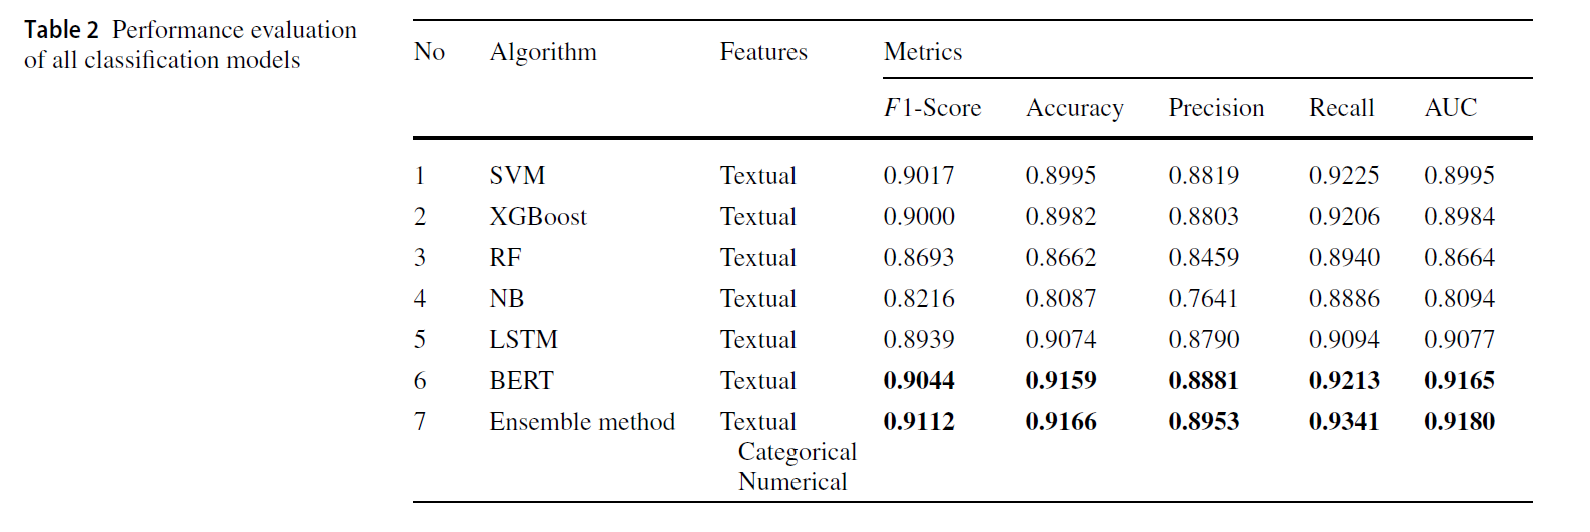

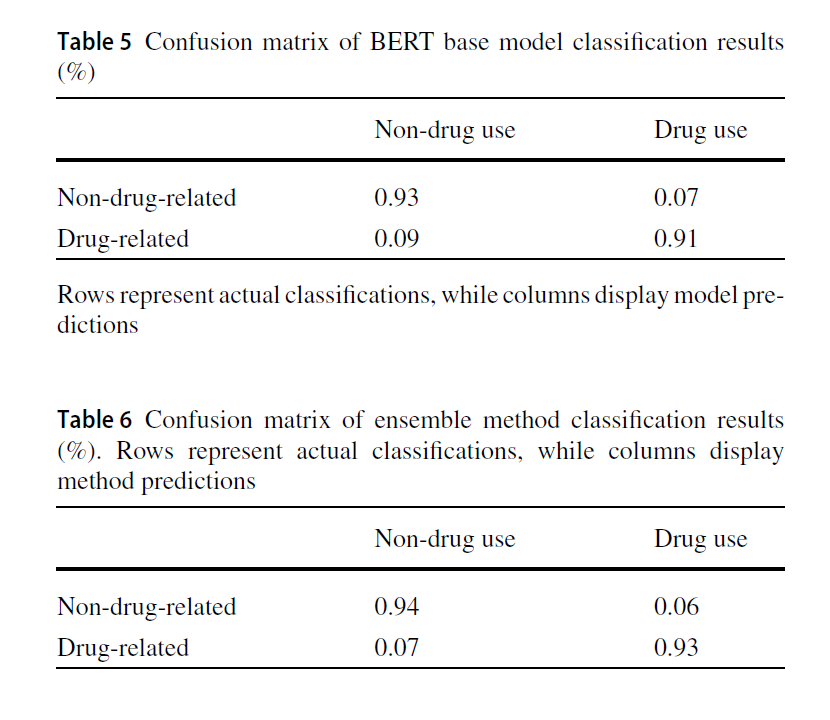